# Gun violence dataset analysis

Antoni Blachnicki - 258332 (223931)   
Aleksander Cholewiński - 258333 (223104)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
gun_data = pd.read_excel('gun_violence_data_2013_2018.xlsx')

## Which state has the most murders?


In [3]:
murders = gun_data['state'].where(gun_data['n_killed'] > 0).value_counts() #where at least 1 person was killed;
print(f"Highest murders: {murders.index[0]} - {murders.iloc[0]}")

Highest murders: California - 4972


## Murder count per 100k population per state

### Get current (2023) population data

In [4]:
#population @2023 source: https://www.statsamerica.org/sip/rank_list.aspx?rank_label=pop1   
import requests
import bs4
req = requests.get("https://www.statsamerica.org/sip/rank_list.aspx?rank_label=pop1")
statePopDict={}
if req.status_code == 200:
    soup = bs4.BeautifulSoup(req.text, 'html.parser')
    table = soup.find_all('table')[0]
    rows = table.find_all('tr')
    for row in rows[1:]:
        cells = row.find_all('td')
        statePopDict[cells[1].text.strip()] = int(cells[3].text.strip().replace(',',''))
else:
    print(f"Request failed with status {req.status_code}")

### Compute murders per 100k
(done in this manner for better scaling of the graph and easier interpretation of data)

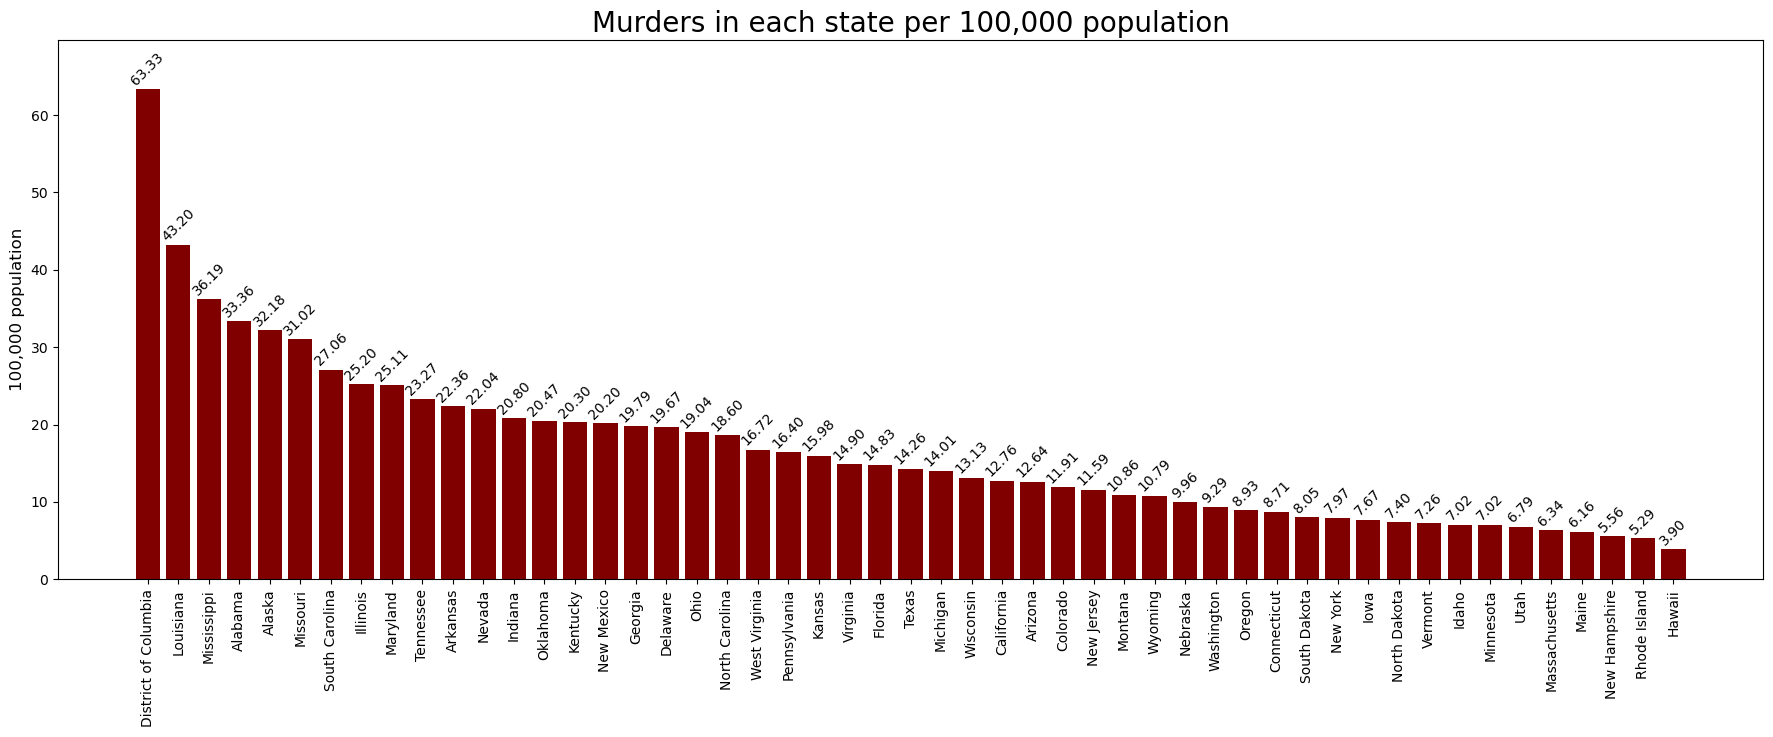

In [5]:
murders = murders.sort_index() #sort alphabetically to match population
popDict = statePopDict 
murDict = {i: murders[i] for i in murders.to_dict().keys()}
#NOTE: scaling down to 'per 100,000' because the scale is awful otherwise

per100Dict = {k: murDict[k]/(int(popDict[k])/100000) for k in murDict}
# moved to another var separate to sort by value descending
per100DictSortedValues = dict(sorted(per100Dict.items(), key=lambda x:x[1], reverse=True))

# render bar chart of murders per 100k population per state
plt.figure(figsize=(22, 7))
plt.title('Murders in each state per 100,000 population', size=20)
barplt = plt.bar(per100DictSortedValues.keys(), per100DictSortedValues.values(), color ='maroon', 
        width = .8)
plt.bar_label(barplt,fmt='%.2f', rotation=45, padding=1, size=10)
plt.ylabel('100,000 population', size=12)
plt.margins(y=0.1)
plt.xticks(rotation=90);

In [6]:
print(f"Highest murder per 100,000 population: {list(per100DictSortedValues)[0]} with {per100DictSortedValues[list(per100DictSortedValues)[0]]:.2f} murders. Overall murders for {list(per100DictSortedValues)[0]}: {murDict[list(per100DictSortedValues)[0]]}")
print(f"California has {per100DictSortedValues['California']:.2f} murders per 100,000 people. Total number of murders in California: {murDict['California']}")

Highest murder per 100,000 population: District of Columbia with 63.33 murders. Overall murders for District of Columbia: 430
California has 12.76 murders per 100,000 people. Total number of murders in California: 4972


As is visible, despite California leading in the amount of murders (gun violence reports with `n_killed` > 0) the per capita amount of murders is almost 5 times lower than in District of Columbia.   
To truly determine which state is the safest, let's take a look at the amount of gun incidents for which `n_killed` > 0 and `n_injured` >= 1

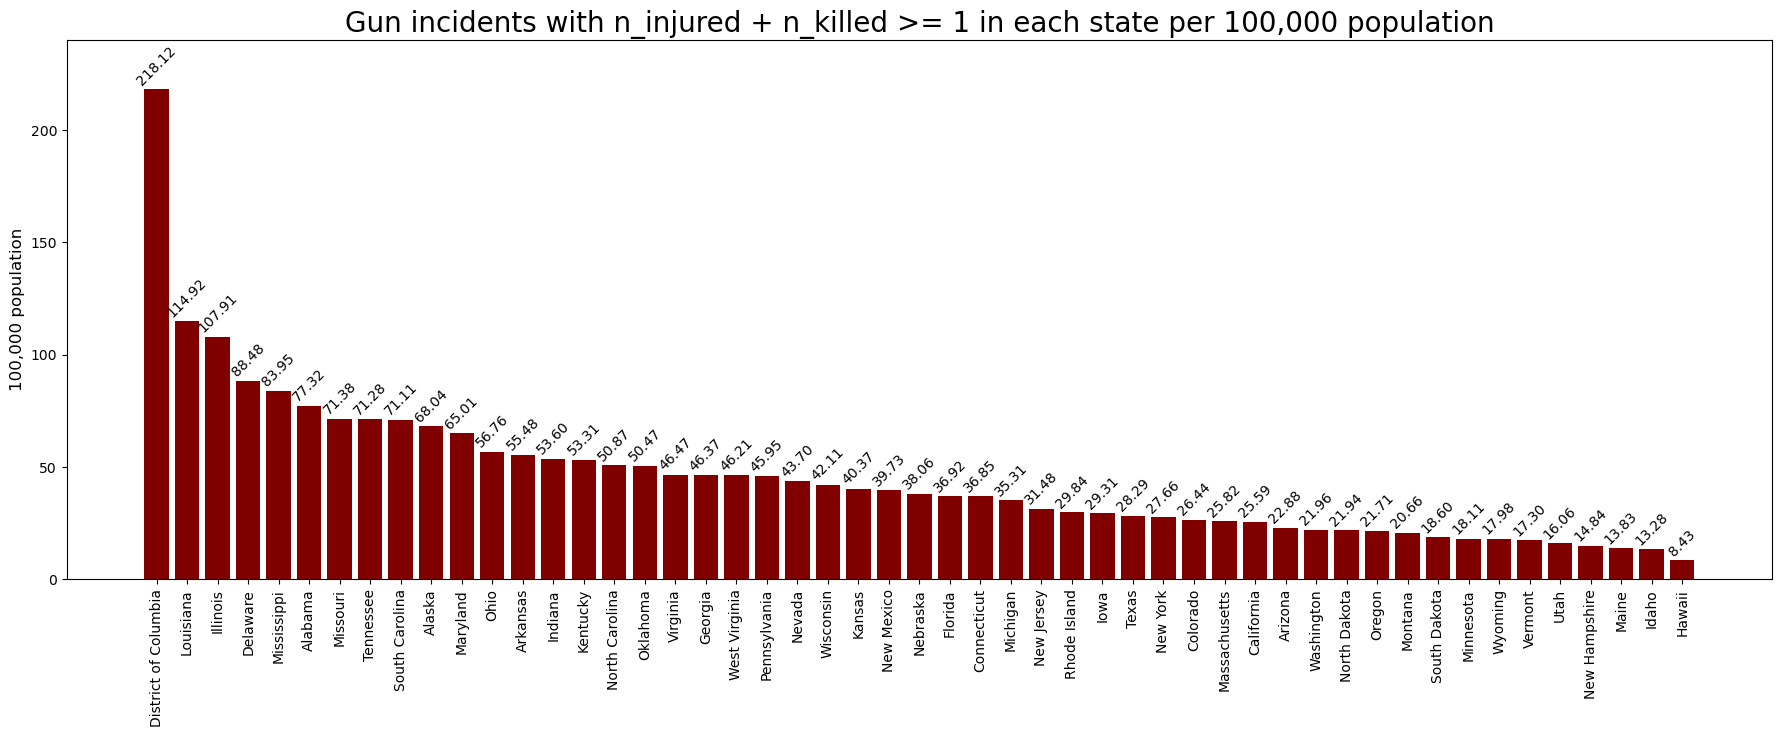

In [7]:
gun_incidents = gun_data[(gun_data['n_killed'] > 0) | (gun_data['n_injured'] > 0)]
gun_incidents_count = gun_incidents['state'].value_counts().sort_index()
gun_incident_dict = {g: gun_incidents_count[g] for g in gun_incidents_count.to_dict().keys()}
per100IncidentDict = {g: gun_incident_dict[g]/(int(popDict[g])/100000) for g in gun_incident_dict}
per100IncidentDictSortedValues = dict(sorted(per100IncidentDict.items(), key=lambda x:x[1], reverse=True))


plt.figure(figsize=(22, 7))
plt.title('Gun incidents with n_injured + n_killed >= 1 in each state per 100,000 population', size=20)
barplt = plt.bar(per100IncidentDictSortedValues.keys(), per100IncidentDictSortedValues.values(), color ='maroon', 
        width = .8)
plt.bar_label(barplt,fmt='%.2f', rotation=45, padding=1, size=10)
plt.ylabel('100,000 population', size=12)
plt.margins(y=0.1)
plt.xticks(rotation=90);

As we can see, even counting incidents fulfilling the criterium of `n_killed + n_injured >= 1` District of Columbia is still the most dangerous state in this regard. At the same time we can conclude the state with the highest murder count (California) to be in the bottom 30% in total gun incident count, hence not being the most dangerous state to live in.

## New dataset creation

In [8]:
with open('new_dataset.csv', 'w') as new_data:
    new_data.write("state,population,murders_total,murder_rate\n")
    for k in murDict:
        new_data.write(f"{k},{popDict[k]},{murDict[k]},{per100Dict[k]}\n")

## Distribution of murders across states

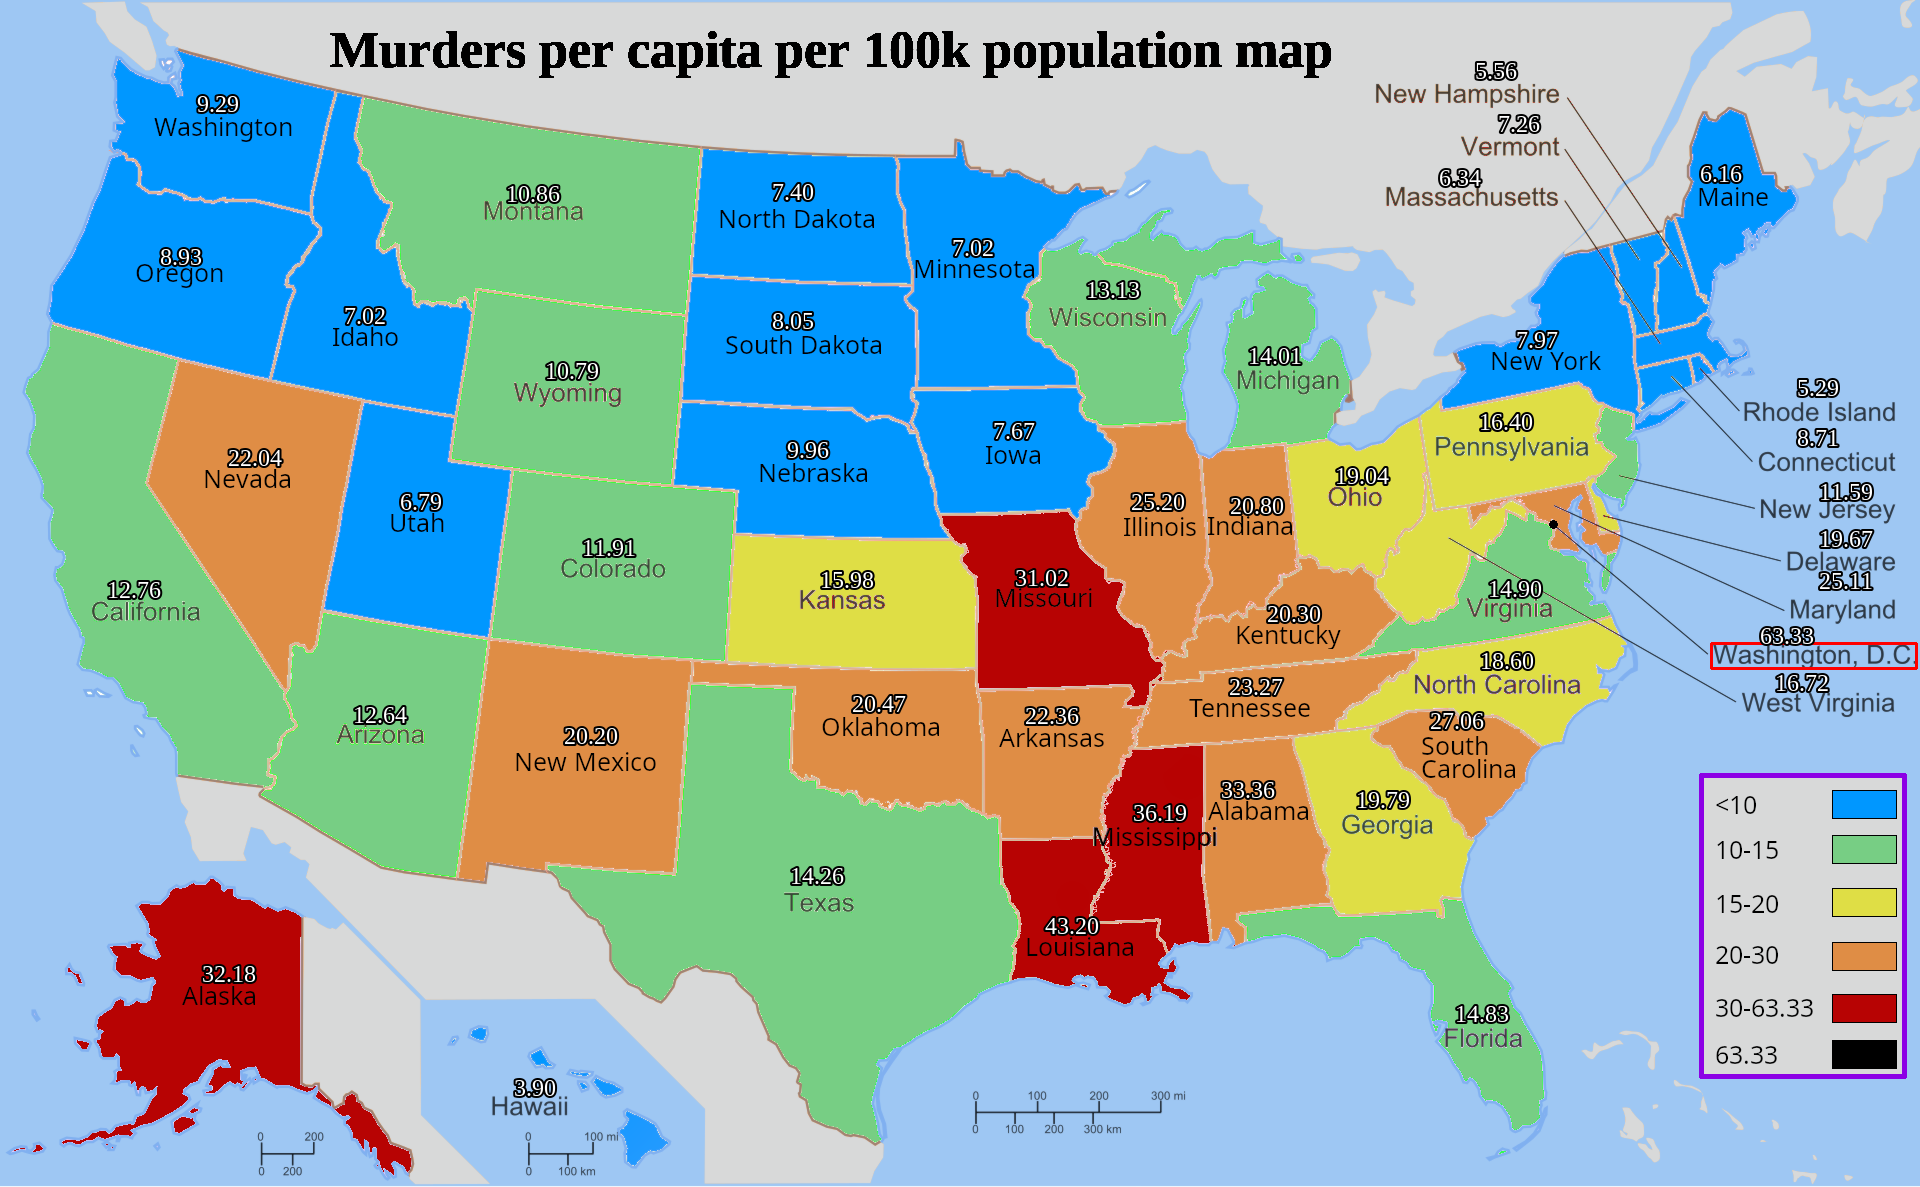

In [9]:
from PIL import Image, ImageFont, ImageDraw
from ast import literal_eval
from matplotlib import font_manager
from matplotlib.patches import Rectangle

img = Image.open('usa_map_2.png')  # Source: https://upload.wikimedia.org/wikipedia/commons/9/92/Map_of_USA_with_state_names_2.svg

drawing = ImageDraw.Draw(img)
system_fonts = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
myFont = ImageFont.truetype('LiberationSerif-Regular.ttf', 24)
titleFont = ImageFont.truetype('LiberationSerif-Bold.ttf', 52)

with open('coords.csv') as coords:
    while line := coords.readline():
        k, coord = line.split('|')
        coord = literal_eval(coord)
        coord[1] -= 18 # move all text draws upwards
        coord = tuple(coord)
        # <10, 10-15, 15-20, 20-30, >30, DC
        # niebieski, zielony, zółty, pomarańczowy, czerwony, czarny
        val = per100Dict[k]
        drawing.text((img.width/2 - 630, 20), 'Murders per capita per 100k population map', font=titleFont, fill=(0,0,0))
        drawing.text(coord, f"{per100Dict[k]:.2f}", font=myFont, stroke_width=2, stroke_fill='black')
# img.draw_rectangle((1687,755), (1900,1023), fill=(125,125,125))

display(img)

Geographically, murder rates seem to be higher on the eastern coast of the USA, with some outliers (e.g. Alaska, Nevada).    
We can also notice that the states in the northern parts tend to have comparatively lower murder rates, similarly with some outliers (Hawaii and Alaska).